# Variational Auto-Encoder

## Importing the libraries and dependencies and drive
The following cell block imports all the libraries, functions, methods that are being used inn this jupyter notebook.<br>
The Deep Learning/Machine Learning Libarary being used here is the high level keras API of tensorflow 2.X.<Br>
And the plotting is done with matplotlib or seaborn plotting packages.

Along with this all the constants that will be common throughout the file are defined and declared here.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import random, math, os, pickle, random, librosa
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from itertools import combinations
%matplotlib inline

EPOCHS = 200
BATCH_SIZE = 128
IMG_SIZE = (28,28)
SEED = 100
CLASSES = 10
LEARNING_RATE = 0.001
ACCURACY_THRESHOLD = 0.98

## Load the data

In [48]:
with open('/content/drive/MyDrive/h5_tr7.pkl', 'rb') as train_file:
    train_data = tf.expand_dims(pickle.load(train_file), axis = -1)
print(train_data.shape)

with open('/content/drive/MyDrive/h5_te7.pkl', 'rb') as test_file:
    test_data = tf.expand_dims(pickle.load(test_file), axis = -1)
print(test_data.shape)

(6265, 28, 28, 1)
(1028, 28, 28, 1)


In [22]:
def seed_everything(n):
    np.random.seed(n)
    random.seed(n)
    tf.random.set_seed(n)

## Model architecture
Using 4 latent dimensions which will be used for controlling the output and for getting new outputs

In [36]:
latent_dim = 4

def VAE(layer_num = 3,
        layer_units = [64, 32, 16],
        kernel_size = [5, 5, 5],
        img_shape = (28, 28, 1),
        latent_dim = latent_dim,
        strides = 1):
    inp = tf.keras.layers.Input(shape = (img_shape))
    en_lyr = tf.keras.layers.Conv2D(layer_units[0], kernel_size[0], strides = strides, activation='relu')(inp)

    for units, kernel in zip(layer_units[1:], kernel_size[1:]):
        en_lyr = tf.keras.layers.Conv2D(units, kernel, strides = strides, activation='relu')(en_lyr)

    en_lyr = tf.keras.layers.Flatten()(en_lyr)
    en_lyr = tf.keras.layers.Dense(1024)(en_lyr)
    encoder_output = tf.keras.layers.Dense(32)(en_lyr)

    mean = tf.keras.layers.Dense(latent_dim)(encoder_output)
    lg_var = tf.keras.layers.Dense(latent_dim)(encoder_output)
     
    epsilon =  tf.keras.backend.random_normal(shape=tf.keras.backend.shape(mean))

    z = mean + tf.keras.backend.exp(0.5 + lg_var) * epsilon

    de_lyr1 = tf.keras.layers.Dense(4, input_shape = z.get_shape())(z)
    de_lyr = tf.keras.layers.Dense(4096)(de_lyr1)
    de_lyr = tf.keras.layers.Reshape((16, 16, 16))(de_lyr)

    de_lyr = tf.keras.layers.Conv2DTranspose(layer_units[-1], kernel_size[-1], strides = strides, activation='relu')(de_lyr)

    for units, kernel in zip(layer_units[::-1][1:], kernel_size[::-1][1:]):
        de_lyr = tf.keras.layers.Conv2DTranspose(units, kernel, strides = strides, activation='relu')(de_lyr)

    # de_lyr = tf.keras.layers.Conv2DTranspose(layer_units[-1], kernel_size[-1], strides = strides, activation='relu')(de_lyr)
    # de_lyr = tf.keras.layers.Dense(28, activation='relu')(de_lyr)
    decoder_output = tf.keras.layers.Conv2D(1, 1)(de_lyr)

    encoder = tf.keras.models.Model(inputs = inp, outputs = [mean, lg_var, z])
    decoder = tf.keras.models.Model(inputs = de_lyr1, outputs = decoder_output)

    autoencoder = tf.keras.models.Model(inputs = inp, outputs = decoder_output)

    return autoencoder, encoder, decoder, mean, lg_var

autoencoder, encoder, decoder, mean, lg_var = VAE()
autoencoder.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 24, 24, 64)   1664        ['input_11[0][0]']               
                                                                                                  
 conv2d_21 (Conv2D)             (None, 20, 20, 32)   51232       ['conv2d_20[0][0]']              
                                                                                                  
 conv2d_22 (Conv2D)             (None, 16, 16, 16)   12816       ['conv2d_21[0][0]']              
                                                                                           

## Custom training function & training



In [42]:
# The following code was taken from Keras documentation

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
vae = VAE(encoder, decoder)
seed_everything(2)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(train_data, epochs=30, batch_size=128)

Epoch 1/30
49/49 [==============================] - 2s 15ms/step - loss: 190.6136 - reconstruction_loss: 164.7514 - kl_loss: 5.5616
Epoch 2/30
49/49 [==============================] - 1s 14ms/step - loss: 154.6501 - reconstruction_loss: 149.1943 - kl_loss: 5.3989
Epoch 3/30
49/49 [==============================] - 1s 14ms/step - loss: 154.3867 - reconstruction_loss: 168.9796 - kl_loss: 3.7293
Epoch 4/30
49/49 [==============================] - 1s 13ms/step - loss: 175.7190 - reconstruction_loss: 161.1765 - kl_loss: 4.3927
Epoch 5/30
49/49 [==============================] - 1s 14ms/step - loss: 150.7601 - reconstruction_loss: 141.1170 - kl_loss: 5.1563
Epoch 6/30
49/49 [==============================] - 1s 14ms/step - loss: 139.8072 - reconstruction_loss: 135.5722 - kl_loss: 5.2023
Epoch 7/30
49/49 [==============================] - 1s 14ms/step - loss: 139.0170 - reconstruction_loss: 131.8354 - kl_loss: 5.4773
Epoch 8/30
49/49 [==============================] - 1s 13ms/step - loss: 133

I tried without the custom training function but somehow my custom loss function was not working so changed to the custom way

In [38]:
#  def vae_loss(ip, op):
#     reconstruction_loss = tf.reduce_mean(
#                 tf.reduce_sum(
#                     tf.keras.losses.binary_crossentropy(ip, op), axis=(1, 2)
#                 )
#             )
#     kl_loss = -0.5 * (1 + lg_var - tf.keras.backend.square(mean) - tf.keras.backend.exp(lg_var))
#     kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
#     total_loss = tf.math.reduce_sum(reconstruction_loss + kl_loss)
#     return tf.convert_to_tensor(total_loss)

# autoencoder.compile(loss = "binary_crossentropy",optimizer = tf.keras.optimizers.Adam())#vae_loss,optimizer = tf.keras.optimizers.Adam())
# autoencoder.fit(train_data, train_data, 
#                 batch_size=64, epochs=50, shuffle = True, 
#                 validation_data = (test_data, test_data))

## Plotting the output

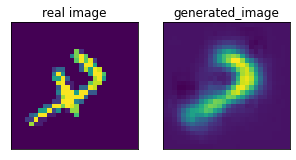

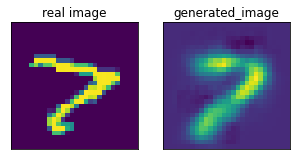

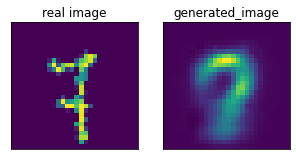

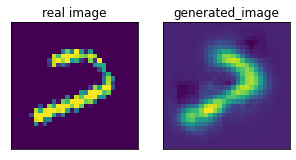

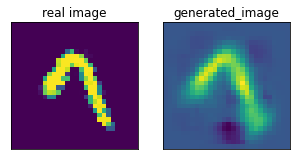

In [43]:
indexes = list(range(100,105))

_,_,pred = encoder.predict(test_data[100:105])
preds = decoder.predict(pred)

for i in range(5):
    plt.figure(figsize=(5, 10))
  
    ax = plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(test_data[indexes[i]]))
    plt.title("real image")
    plt.axis('off')
  
    ax = plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(preds[i]))
    plt.title('generated_image')
    plt.axis('off')

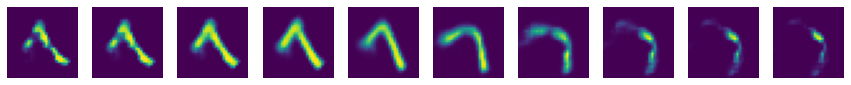

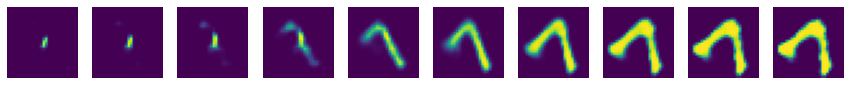

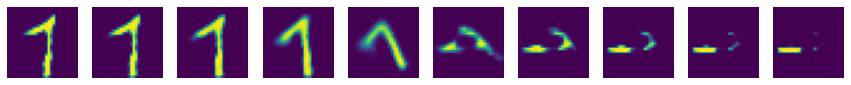

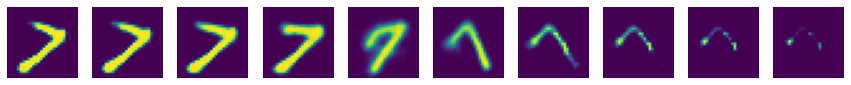

In [93]:
_,_,pred = encoder.predict(np.expand_dims(test_data[img_idx], 0))
img_idx = 1010
for dim in range(latent_dim):
    i = 0
    plt.figure(figsize=(15, 15))
    for new_val in np.linspace(-10, 10, 10):
        ax = plt.subplot(1, 10, i+1)
        temp_vec = pred.copy()
        temp_vec[0, dim] = new_val
        plt.imshow(np.squeeze(decoder.predict(temp_vec)))
        plt.axis('off')
        i+=1
    plt.show()

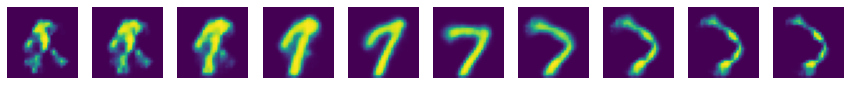

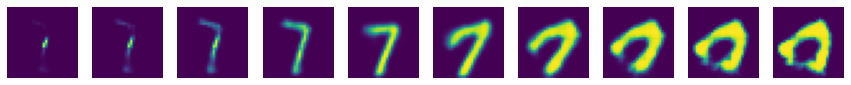

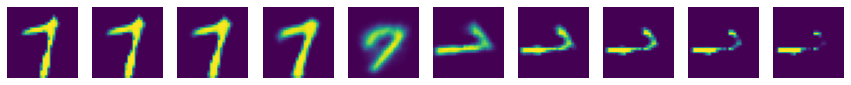

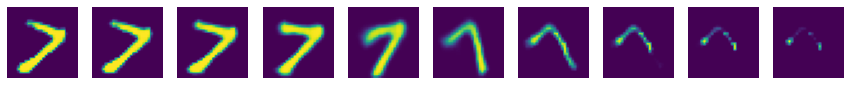

In [95]:
img_idx = 10
_,_,pred = encoder.predict(np.expand_dims(test_data[img_idx], 0))
for dim in range(latent_dim):
    new_vecs = []
    i = 0
    plt.figure(figsize=(15, 15))
    for new_val in np.linspace(-10, 10, 10):
        ax = plt.subplot(1, 10, i+1)
        temp_vec = pred.copy()
        temp_vec[0, dim] = new_val
        plt.imshow(np.squeeze(decoder.predict(temp_vec)))
        plt.axis('off')
        i+=1
    plt.show()

## Conculsion & Findings
As can be seen from the above plots the 4 latent dimensions control the dollowing :-
- 1st dimension - Rotation
- 2nd Dimension - Thickness
- 3rd Dimension - size of the horizontal line
- 4th Dimension - Rotation
